En este notebook analizare los datos de los recursos para identificar si es estacionaria y si se pueden aplicar modelos de medias moviles o ARDL


In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [10]:
# Fetch data
url = "http://127.0.0.1:8000/api/v1/data/?table_name=precios_materiales&limit=1000"

try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    print(f"✓ Successfully fetched {len(data['data'])} records")
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    raise


✓ Successfully fetched 190 records


In [11]:
# Convert to Data Frame
df = pd.DataFrame(data['data'])

#Convert date to date of Dataframe
df['date'] = pd.to_datetime(df['date'])

# Df sort by date
df = df.sort_values('date')

print(df.info())
print(df.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    190 non-null    int64         
 1   date                  190 non-null    datetime64[ns]
 2   year                  190 non-null    int64         
 3   scrap                 190 non-null    float64       
 4   gas                   190 non-null    float64       
 5   rebar                 190 non-null    float64       
 6   hrcc1                 190 non-null    float64       
 7   scrap_mxn             190 non-null    float64       
 8   gas_mxn               190 non-null    float64       
 9   rebar_mxn             190 non-null    float64       
 10  hrcc1_mxn             190 non-null    float64       
 11  tipo_de_cambio        190 non-null    float64       
 12  varilla_distribuidor  190 non-null    float64       
 13  varilla_credito     

CORRELATION MATRIX
Columnas disponibles: ['scrap_mxn', 'gas_mxn', 'rebar_mxn', 'tipo_de_cambio', 'varilla_distribuidor', 'varilla_credito', 'precio_mercado']
Columnas no encontradas: set()
                      scrap_mxn   gas_mxn  rebar_mxn  tipo_de_cambio  \
scrap_mxn              1.000000  0.458997   0.929133        0.511945   
gas_mxn                0.458997  1.000000   0.673854        0.665693   
rebar_mxn              0.929133  0.673854   1.000000        0.654376   
tipo_de_cambio         0.511945  0.665693   0.654376        1.000000   
varilla_distribuidor   1.000000  0.458997   0.929133        0.511945   
varilla_credito        1.000000  0.458997   0.929133        0.511945   
precio_mercado         1.000000  0.458997   0.929133        0.511945   

                      varilla_distribuidor  varilla_credito  precio_mercado  
scrap_mxn                         1.000000         1.000000        1.000000  
gas_mxn                           0.458997         0.458997        0.458997  


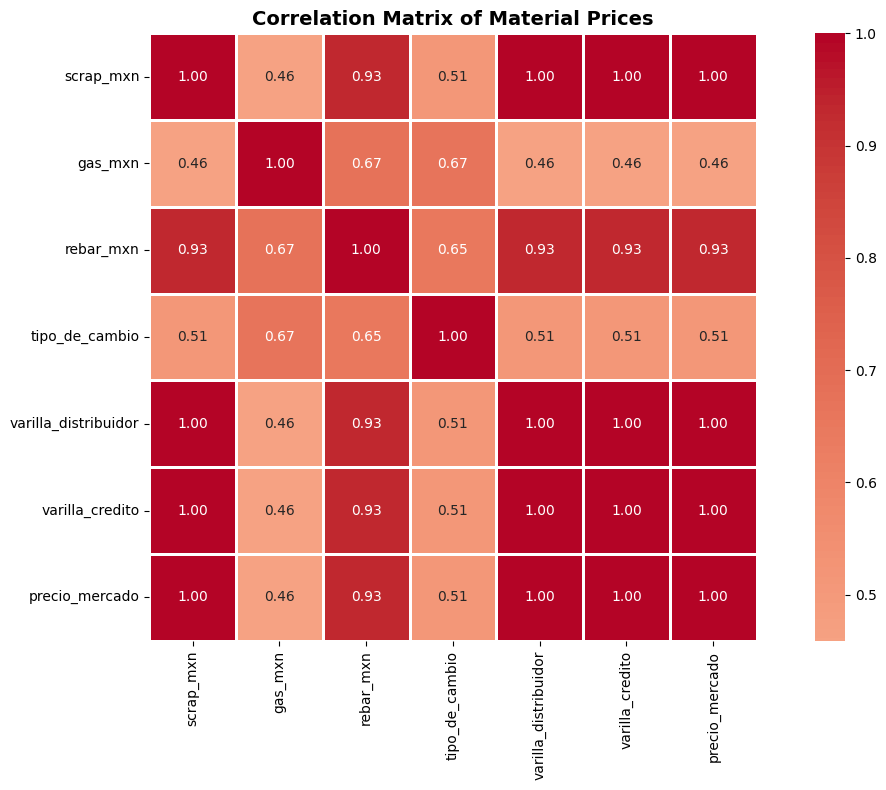

In [17]:
print("CORRELATION MATRIX")

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

selected_columns = ['scrap_mxn', 'gas_mxn', 'rebar_mxn', 'tipo_de_cambio', 
                   'varilla_distribuidor', 'varilla_credito', 'precio_mercado']

available_columns = [col for col in selected_columns if col in df.columns]
print(f"Columnas disponibles: {available_columns}")
print(f"Columnas no encontradas: {set(selected_columns) - set(available_columns)}")

correlation_matrix = df[available_columns].corr()
print(correlation_matrix)


plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix of Material Prices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Esta matriz muestra la correlacion entre los precios de los materiales en el tiempo.

1 es una correlacion perfecta, -1 es una correlacion perfecta negativa, 0 es no correlacion.

Si analizamos la primer fila, que es scap_mx, vemos que el precio de la chatarra esta relacionao con el precio de la varilla, y obvio del precio del precio de la varilla del distribuidor, credito y precio del mercado

Correlaciones bajas, <51% - Sugiere que el precio del gas en pesos se relaciona moderadamente con el tipo de cambio

Esto puedo deducir que utlizando un modelo predictivo o una regreson, puedo usar una o dos variables de este tipo ejemplo un primer analisis seria scrap_mxn y rebar_mxn como variables predictoras.








In [21]:
import statsmodels.api as sm

# Variables independientes
X = df[['scrap_mxn', 'gas_mxn', 'rebar_mxn', 'tipo_de_cambio']]
# Variable dependiente
y = df['varilla_distribuidor']

#https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())



                                  OLS Regression Results                                 
Dep. Variable:     varilla_distribuidor   R-squared (uncentered):                   1.000
Model:                              OLS   Adj. R-squared (uncentered):              1.000
Method:                   Least Squares   F-statistic:                          5.010e+16
Date:                  Mon, 20 Oct 2025   Prob (F-statistic):                        0.00
Time:                          11:18:16   Log-Likelihood:                          1177.4
No. Observations:                   190   AIC:                                     -2347.
Df Residuals:                       186   BIC:                                     -2334.
Df Model:                             4                                                  
Covariance Type:              nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------


Que es el modelo OSL, es el ordinary least squares, 
es un modelo de regresion lineal que busca minimizar 
la suma de los cuadrados de los errores.

Esto quiere decir que es un model que sirve para entender y medir la relacion entre una variable principal
y otras variables que pueden ayudar a predecir su comportamiento.

En este caso queremos explicar com ocambia el precio de la varilla del distribuidor.
usando las posibles explicaciones como son variables independientes que son scrap_mxn, gas_mxn, rebar_mxn, tipo_de_cambio.

Resumen: nos dice cuanto cambia el precio de la varilla cuando cambian los precios de otros materiales o el dolar.

Scrap = Fuerte relacion positiva
gas = relacion muy debil
rebar = relacion debil
tipo de cambio = influencia ligera = Si el dolar sube, el precio de la varilla tiende a aumentar un poco. 


p < 0.05 Significativo
0.05 ≤ p < 0.10 Marginalmente significativo
p ≥ 0.10 No significativo
